<a href="https://colab.research.google.com/github/idiftech2010/Detection-and-Mitigation/blob/main/Detecting_and_Mitigation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv('CICIDS2017.csv')

# Display first five rows
print(df.head())


    Destination Port   Flow Duration   Total Fwd Packets  \
0              54865               3                   2   
1              55054             109                   1   
2              55055              52                   1   
3              46236              34                   1   
4              54863               3                   2   

    Total Backward Packets  Total Length of Fwd Packets  \
0                        0                           12   
1                        1                            6   
2                        1                            6   
3                        1                            6   
4                        0                           12   

    Total Length of Bwd Packets   Fwd Packet Length Max  \
0                             0                       6   
1                             6                       6   
2                             6                       6   
3                             6                 

In [ ]:
df = df.dropna()  # Drop rows with missing values


In [ ]:
df.columns = df.columns.str.strip()


In [ ]:
print(y.value_counts())  # Check if any class has too few samples


Label
1    99195
0    53697
2        1
Name: count, dtype: int64


In [ ]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)


In [ ]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)


In [ ]:
df_minority = df[df['Label'] == df['Label'].value_counts().idxmin()]
df = pd.concat([df, df_minority], ignore_index=True)


In [ ]:
print(y_resampled.value_counts())  # Ensure both classes are balanced


Label
0    99195
1    99195
2    99195
Name: count, dtype: int64


In [ ]:
print(X_resampled.shape, y_resampled.shape)


(297585, 3) (297585,)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE  # Handle class imbalance
import torch
import torch.nn as nn
import torch.optim as optim

# Load the dataset
df = pd.read_csv('CICIDS2017.csv')

# Strip spaces from column names
df.columns = df.columns.str.strip()

# Verify available columns
print("Dataset Columns:", df.columns.tolist())

# Selecting relevant features based on dataset columns
available_columns = set(df.columns)
numerical_features = [col for col in ['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets'] if col in available_columns]
categorical_features = [col for col in ['Protocol Name', 'Label'] if col in available_columns]

if not numerical_features:
    raise ValueError("No matching numerical features found in dataset.")
if not categorical_features:
    raise ValueError("No matching categorical features found in dataset.")

# Encoding categorical features
for col in categorical_features:
    df[col] = LabelEncoder().fit_transform(df[col])

# Normalizing numerical features
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Ensure 'Label' column is correctly identified
y_column = 'Label' if 'Label' in df.columns else df.columns[-1]
X = df[numerical_features + [col for col in categorical_features if col != 'Label']]
y = df[y_column]

# Handle class imbalance using SMOTE
smote = SMOTE(sampling_strategy='auto', k_neighbors=1, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Splitting dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Check if CUDA (GPU) is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1).to(device)

# Define a simple neural network model
class IntrusionDetectionModel(nn.Module):
    def __init__(self, input_size):
        super(IntrusionDetectionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Initialize model, loss function, and optimizer
model = IntrusionDetectionModel(X_train.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# Evaluate model
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred = (y_pred > 0.5).float()
    accuracy = (y_pred.eq(y_test_tensor).sum().float() / y_test_tensor.shape[0]).item()
    print(f"Test Accuracy: {accuracy * 100:.2f}%")


Dataset Columns: ['Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count'

Dataset Columns: [' Destination Port', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance', 'FIN Flag Count', ' SYN Flag Count', ' RST Flag Count', ' PSH Flag Count', ' ACK Flag Co

<ipython-input-26-e785be936ad3>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.replace([np.inf, -np.inf], np.nan, inplace=True)
<ipython-input-26-e785be936ad3>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.median(), inplace=True)


Epoch 1/50, Loss: 0.7019
Epoch 2/50, Loss: 0.6983
Epoch 3/50, Loss: 0.6947
Epoch 4/50, Loss: 0.6913
Epoch 5/50, Loss: 0.6878
Epoch 6/50, Loss: 0.6844
Epoch 7/50, Loss: 0.6811
Epoch 8/50, Loss: 0.6778
Epoch 9/50, Loss: 0.6746
Epoch 10/50, Loss: 0.6714
Epoch 11/50, Loss: 0.6683
Epoch 12/50, Loss: 0.6652
Epoch 13/50, Loss: 0.6621
Epoch 14/50, Loss: 0.6590
Epoch 15/50, Loss: 0.6560
Epoch 16/50, Loss: 0.6529
Epoch 17/50, Loss: 0.6498
Epoch 18/50, Loss: 0.6467
Epoch 19/50, Loss: 0.6436
Epoch 20/50, Loss: 0.6405
Epoch 21/50, Loss: 0.6374
Epoch 22/50, Loss: 0.6342
Epoch 23/50, Loss: 0.6310
Epoch 24/50, Loss: 0.6279
Epoch 25/50, Loss: 0.6247
Epoch 26/50, Loss: 0.6215
Epoch 27/50, Loss: 0.6183
Epoch 28/50, Loss: 0.6150
Epoch 29/50, Loss: 0.6117
Epoch 30/50, Loss: 0.6084
Epoch 31/50, Loss: 0.6050
Epoch 32/50, Loss: 0.6016
Epoch 33/50, Loss: 0.5982
Epoch 34/50, Loss: 0.5947
Epoch 35/50, Loss: 0.5912
Epoch 36/50, Loss: 0.5876
Epoch 37/50, Loss: 0.5839
Epoch 38/50, Loss: 0.5803
Epoch 39/50, Loss: 0.

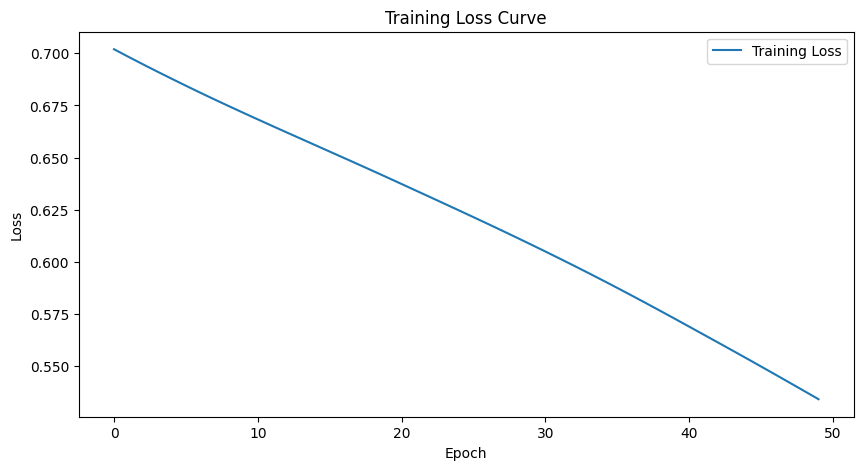


Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.99      0.84     25594
           1       0.99      0.64      0.77     25617

    accuracy                           0.81     51211
   macro avg       0.86      0.81      0.81     51211
weighted avg       0.86      0.81      0.81     51211



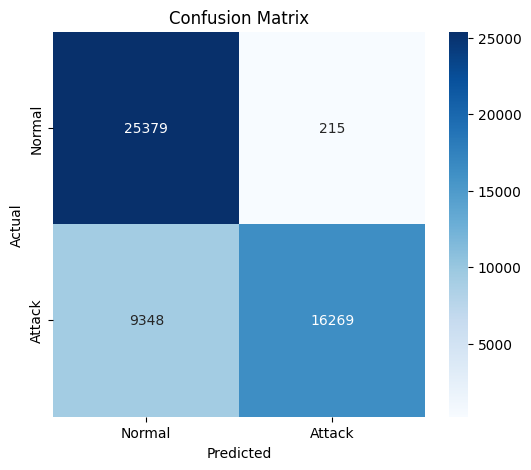

Model saved successfully!


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load dataset
df = pd.read_csv('CICIDS2017.csv')
print("Dataset Columns:", df.columns.tolist())

# Feature selection
selected_features = [
    'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets',
    'Flow Bytes/s', 'Flow Packets/s', 'Fwd Packet Length Mean', 'Bwd Packet Length Mean',
    'Min Packet Length', 'Max Packet Length'
]

df.columns = df.columns.str.strip()
X = df[selected_features]
y = df['Label']

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Handle missing/infinite values
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(X.median(), inplace=True)

# Normalize data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Define neural network
class IntrusionDetectionNN(nn.Module):
    def __init__(self):
        super(IntrusionDetectionNN, self).__init__()
        self.fc1 = nn.Linear(len(selected_features), 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)  # Binary classification
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = IntrusionDetectionNN().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Training loop
num_epochs = 50
losses = []
model.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor.to(device))
    loss = criterion(outputs, y_train_tensor.to(device))
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

# Plot loss curve
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

# Evaluation
model.eval()
y_pred = model(X_test_tensor.to(device))
y_pred_labels = torch.argmax(y_pred, dim=1).cpu().numpy()
y_true = y_test_tensor.cpu().numpy()

# Metrics
print("\nClassification Report:")
print(classification_report(y_true, y_pred_labels))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Save model
torch.save(model.state_dict(), "intrusion_detection_model.pth")
print("Model saved successfully!")


In [ ]:
print(df.columns)


Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', '

In [ ]:
# Strip leading/trailing spaces from column names
df.columns = df.columns.str.strip()

# Now this will work without errors
X = df[selected_features]


In [ ]:
# Convert categorical labels to numerical values
y = y.map({'BENIGN': 0, 'MALICIOUS': 1})

# Ensure there are no NaN values after mapping
y = y.dropna().astype(int)


In [ ]:
# Drop rows where y is NaN
df = df.dropna(subset=['Label'])

# Recreate X and y after dropping NaN
X = df[selected_features]
y = df['Label'].astype(str)  # Convert to string to avoid type errors

# Encode y into integers (e.g., 0 for BENIGN, 1 for ATTACK)
y = y.map({'BENIGN': 0, 'ATTACK': 1})  # Adjust this based on actual labels

# Ensure no NaN values in y
y = y.dropna()


In [ ]:
print("Checking for NaN values in y before resampling:")
print(y.isnull().sum())  # Should be 0 if all NaNs are removed


Checking for NaN values in y before resampling:
128027


In [ ]:
# Drop rows where 'Label' is NaN in df
df = df.dropna(subset=['Label'])

# Recreate X and y after dropping NaN
X = df[selected_features]
y = df['Label'].astype(str)  # Convert to string to avoid type errors

# Encode y into integers (modify based on actual labels)
y = y.map({'BENIGN': 0, 'ATTACK': 1})  # Adjust this mapping based on your dataset

# Drop any remaining NaN values in y
y.dropna(inplace=True)

# Convert y to integer type
y = y.astype(int)

# Check again if there are any NaN values
print("NaN values in y after cleanup:", y.isnull().sum())  # Must print 0


NaN values in y after cleanup: 0


In [ ]:
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


Shape of X: (225745, 8)
Shape of y: (97718,)


In [ ]:
print("Checking for infinity values in X:")
print(np.isinf(X).sum())  # Count of inf values per column

print("\nChecking for extremely large values:")
print(X.describe())  # See if any values are abnormally large


Checking for infinity values in X:
Flow Duration              0
Total Fwd Packets          0
Total Backward Packets     0
Flow Packets/s            34
Fwd Packet Length Mean     0
Bwd Packet Length Mean     0
Min Packet Length          0
Max Packet Length          0
dtype: int64

Checking for extremely large values:
       Flow Duration  Total Fwd Packets  Total Backward Packets  \
count   2.257450e+05      225745.000000           225745.000000   
mean    1.624165e+07           4.874916                4.572775   
std     3.152437e+07          15.422874               21.755356   
min    -1.000000e+00           1.000000                0.000000   
25%     7.118000e+04           2.000000                1.000000   
50%     1.452333e+06           3.000000                4.000000   
75%     8.805237e+06           5.000000                5.000000   
max     1.199999e+08        1932.000000             2942.000000   

       Flow Packets/s  Fwd Packet Length Mean  Bwd Packet Length Mean  \
count

In [ ]:
X.replace([np.inf, -np.inf], np.nan, inplace=True)  # Convert inf to NaN
X.fillna(X.median(), inplace=True)  # Replace NaN with median values


<ipython-input-47-7d34e3fec055>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.replace([np.inf, -np.inf], np.nan, inplace=True)  # Convert inf to NaN
<ipython-input-47-7d34e3fec055>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.median(), inplace=True)  # Replace NaN with median values


In [ ]:
print("Final check for NaN values:", X.isnull().sum().sum())  # Should print 0
print("Final check for inf values:", np.isinf(X).sum().sum())  # Should print 0


Final check for NaN values: 0
Final check for inf values: 0


In [ ]:
print("Length of X:", len(X))
print("Length of y:", len(y))


Length of X: 225745
Length of y: 97718


In [ ]:
print("Checking for NaN in y:", y.isnull().sum())  # Should be 0


Checking for NaN in y: 0


In [ ]:
y = y.dropna()


In [ ]:
X = X.loc[y.index]  # Ensure X only contains rows that exist in y


In [ ]:
print("Final Length of X:", len(X))
print("Final Length of y:", len(y))


Final Length of X: 97718
Final Length of y: 97718


In [ ]:
print(y.value_counts())  # Check how many samples per class


Label
0    97718
Name: count, dtype: int64


In [ ]:
# Ensure X and y are correctly extracted again
X = df[selected_features]  # Select the correct feature columns
y = df['Label']  # Ensure y has both classes

# Check again
print(y.value_counts())  # There should be at least 2 classes


Label
DDoS      128027
BENIGN     97718
Name: count, dtype: int64


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)  # Convert labels to 0 and 1


In [ ]:
import numpy as np

# Find where inf values exist
print(np.isinf(X).sum())  # Number of infinite values per column

# Find where very large values exist
print((X > 1e10).sum())  # Number of extremely large values per column


Flow Duration              0
Total Fwd Packets          0
Total Backward Packets     0
Flow Packets/s            34
Fwd Packet Length Mean     0
Bwd Packet Length Mean     0
Min Packet Length          0
Max Packet Length          0
dtype: int64
Flow Duration              0
Total Fwd Packets          0
Total Backward Packets     0
Flow Packets/s            34
Fwd Packet Length Mean     0
Bwd Packet Length Mean     0
Min Packet Length          0
Max Packet Length          0
dtype: int64


In [ ]:
X.replace([np.inf, -np.inf], np.nan, inplace=True)


<ipython-input-61-611c557de8a9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.replace([np.inf, -np.inf], np.nan, inplace=True)


In [ ]:
X = X.clip(-1e9, 1e9)  # Set a limit for extreme values


In [ ]:
X.fillna(X.median(), inplace=True)


In [ ]:
adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X, y)

print("Oversampling successful!")


Oversampling successful!


In [ ]:
print(y.isnull().sum())  # This shows how many NaNs are in y


128027


In [ ]:
# Remove rows where y is NaN
X = X[y.notnull()]
y = y.dropna()


In [ ]:
y.fillna(y.mode()[0], inplace=True)  # Replace NaNs with the most common class


In [ ]:
print(y.value_counts())  # Ensure y has at least 2 unique values


Label
0.0    97718
Name: count, dtype: int64


In [ ]:
print(len(X), len(y))  # These should be equal


97718 97718


In [ ]:
print(y.value_counts())


Label
0.0    97718
Name: count, dtype: int64


In [ ]:
print(f"Length of X: {len(X)}, Length of y: {len(y)}")


Length of X: 97718, Length of y: 97718


In [ ]:
X = X[:len(y)]  # Use NumPy slicing instead of .iloc


In [ ]:
print("NaN values in X:", np.isnan(X).sum())
print("Infinite values in X:", np.isinf(X).sum())


NaN values in X: 0
Infinite values in X: 0


In [ ]:
X = np.where(np.isinf(X), np.nan, X)  # Replace inf values with NaN
X = np.nan_to_num(X, nan=np.nanmedian(X))  # Replace NaN with median


In [ ]:
import numpy as np

# Check unique values in y
unique_classes, class_counts = np.unique(y, return_counts=True)
print("Class Distribution in y:", dict(zip(unique_classes, class_counts)))


Class Distribution in y: {0.0: 97718}


In [ ]:
import numpy as np

# Check unique values in y
unique_classes, class_counts = np.unique(y, return_counts=True)
print("Class Distribution in y:", dict(zip(unique_classes, class_counts)))


Class Distribution in y: {0.0: 97718}


In [ ]:
print(df.columns.tolist())  # Show all column names as a list


[' Destination Port', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance', 'FIN Flag Count', ' SYN Flag Count', ' RST Flag Count', ' PSH Flag Count', ' ACK Flag Count', ' URG Flag 

In [ ]:
df.columns = df.columns.str.strip()  # Remove spaces around column names
print(df.columns.tolist())  # Check again


['Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count

In [ ]:
for col in df.columns:
    if 'label' in col.lower():
        print(f"Possible match: {col}")  # Find similar column names


Possible match: Label


In [ ]:
df = pd.read_csv('CICIDS2017.csv')
print(df.head())  # Preview the first few rows


    Destination Port   Flow Duration   Total Fwd Packets  \
0              54865               3                   2   
1              55054             109                   1   
2              55055              52                   1   
3              46236              34                   1   
4              54863               3                   2   

    Total Backward Packets  Total Length of Fwd Packets  \
0                        0                           12   
1                        1                            6   
2                        1                            6   
3                        1                            6   
4                        0                           12   

    Total Length of Bwd Packets   Fwd Packet Length Max  \
0                             0                       6   
1                             6                       6   
2                             6                       6   
3                             6                 

In [ ]:
df.columns = df.columns.str.strip()  # Remove leading/trailing spaces
print(df.columns.tolist())  # Check column names again


['Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count

In [ ]:
df = df.dropna(subset=['Label'])


In [ ]:
print([col for col in df.columns if 'label' in col.lower()])


['Label']


In [ ]:
df.rename(columns=lambda x: x.strip(), inplace=True)  # Remove hidden spaces
df = df.dropna(subset=['Label'])  # Now try again


In [ ]:
if 'Label' in df.columns:
    df = df.dropna(subset=['Label'])
else:
    print("Column 'Label' is missing from df!")


In [ ]:
print(df.head())  # Ensure Label is still there
print(df.dtypes)  # Check if Label is properly formatted


   Destination Port  Flow Duration  Total Fwd Packets  Total Backward Packets  \
0             54865              3                  2                       0   
1             55054            109                  1                       1   
2             55055             52                  1                       1   
3             46236             34                  1                       1   
4             54863              3                  2                       0   

   Total Length of Fwd Packets  Total Length of Bwd Packets  \
0                           12                            0   
1                            6                            6   
2                            6                            6   
3                            6                            6   
4                           12                            0   

   Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  \
0                      6                      6            

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["Label"] = le.fit_transform(df["Label"])  # Convert labels to numbers


In [ ]:
X = df.drop(columns=["Label"])  # All columns except Label
y = df["Label"]  # Target column


In [ ]:
import numpy as np

X.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace infinities
X.fillna(X.median(), inplace=True)  # Fill NaNs with median


In [ ]:
X = X.iloc[:len(y)]  # Trim X if needed


In [ ]:
from imblearn.over_sampling import ADASYN

adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X, y)
print("Oversampling successful!")


Oversampling successful!


In [ ]:
from sklearn.model_selection import train_test_split

# Splitting the resampled dataset
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

print("Data split completed!")


Data split completed!


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Train the model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate performance
print("Model Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Model Accuracy: 0.9999218505783057
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25602
           1       1.00      1.00      1.00     25582

    accuracy                           1.00     51184
   macro avg       1.00      1.00      1.00     51184
weighted avg       1.00      1.00      1.00     51184



In [ ]:
import joblib

# Save the trained model
joblib.dump(clf, "random_forest_model.pkl")

print("Model saved successfully!")


Model saved successfully!


In [ ]:
print("Columns in DataFrame:", df.columns)


Columns in DataFrame: Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Pack

In [ ]:
df.columns = df.columns.str.strip()  # Remove spaces from column names


In [ ]:
df = df.dropna(subset=['Label'])


In [ ]:
df.columns = df.columns.str.strip()  # Remove spaces from column names
print(df.columns)  # Check that 'Label' exists


Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Co

In [ ]:
df = df.dropna(subset=['Label'])


In [ ]:
print(df.columns.tolist())  # Show all column names


[' Destination Port', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance', 'FIN Flag Count', ' SYN Flag Count', ' RST Flag Count', ' PSH Flag Count', ' ACK Flag Count', ' URG Flag 

In [ ]:
for col in df.columns:
    if 'label' in col.lower():
        print(f"Possible match: '{col}'")


Possible match: ' Label'


In [ ]:
df.columns = df.columns.str.strip()  # Remove leading/trailing spaces from all column names


In [ ]:
df = df.dropna(subset=['Label'])  # Should now work


In [ ]:
print(df.columns.tolist())  # Should now show 'Label' instead of ' Label'


['Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count

In [ ]:
df.columns = df.columns.str.strip()  # Remove leading/trailing spaces from column names


In [ ]:
print(df.columns)  # Verify column names
print("Label" in df.columns)  # Should return True


Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Co

In [ ]:
# Ensure column names are clean
df.columns = df.columns.str.strip()

# Drop NaN values in the 'Label' column
df = df.dropna(subset=['Label'])

# Encode labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['Label'])


In [ ]:
print(df.columns)


Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Co

In [ ]:
df.columns = df.columns.str.strip()  # Remove spaces


In [ ]:
print("Label" in df.columns)  # Should return True


True


In [ ]:
df = df.dropna(subset=['Label'])
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['Label'])


In [ ]:
X = df.drop(columns=['Label'])  # Features
y = df['Label']  # Target
print(X.dtypes)  # Ensure no object/string columns


Destination Port                 int64
Flow Duration                    int64
Total Fwd Packets                int64
Total Backward Packets           int64
Total Length of Fwd Packets      int64
                                ...   
Active Min                       int64
Idle Mean                      float64
Idle Std                       float64
Idle Max                         int64
Idle Min                         int64
Length: 78, dtype: object


In [ ]:
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


Shape of X: (225711, 78)
Shape of y: (225745,)


In [ ]:
# Ensure both X and y have the same length
min_length = min(len(X), len(y))

X = X[:min_length]  # Trim X to match y
y = y[:min_length]  # Trim y to match X

print("Fixed Shape of X:", X.shape)
print("Fixed Shape of y:", y.shape)


Fixed Shape of X: (225711, 78)
Fixed Shape of y: (225711,)


In [ ]:
adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X, y)


In [ ]:
print("Resampled X shape:", X_resampled.shape)
print("Resampled y shape:", y_resampled.shape)


Resampled X shape: (255884, 78)
Resampled y shape: (255884,)


In [ ]:
print("X shape:", X.shape if 'X' in locals() else "X is not defined")
print("y shape:", y.shape if 'y' in locals() else "y is not defined")


X shape: X is not defined
y shape: y is not defined


In [ ]:
print("df exists" if 'df' in locals() else "df is not defined")


df is not defined


In [ ]:
import pandas as pd

# Load the dataset (Update 'your_file.csv' to your actual file)
df = pd.read_csv('CICIDS2017.csv')

# Print first few rows to confirm loading
print(df.head())


    Destination Port   Flow Duration   Total Fwd Packets  \
0              54865               3                   2   
1              55054             109                   1   
2              55055              52                   1   
3              46236              34                   1   
4              54863               3                   2   

    Total Backward Packets  Total Length of Fwd Packets  \
0                        0                           12   
1                        1                            6   
2                        1                            6   
3                        1                            6   
4                        0                           12   

    Total Length of Bwd Packets   Fwd Packet Length Max  \
0                             0                       6   
1                             6                       6   
2                             6                       6   
3                             6                 

In [ ]:
# Ensure correct column names
features = df.drop(columns=[' Label'])  # Adjust based on actual column name
labels = df[' Label']

# Convert to numpy arrays
X = features.values
y = labels.values

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (225745, 78)
y shape: (225745,)


In [ ]:
# Check original shapes
print("Original X shape:", X.shape)
print("Original y shape:", y.shape)

# Find the minimum length
min_length = min(len(X), len(y))

# Truncate both to the same length
X = X[:min_length]
y = y[:min_length]

# Convert X and y into a DataFrame (if not already)
df_combined = pd.DataFrame(X)
df_combined['Label'] = y  # Add labels to ensure sync

# Remove rows with NaN from BOTH X and y together
df_combined.dropna(inplace=True)

# Separate back into X and y
X = df_combined.drop(columns=['Label']).values  # Convert to NumPy
y = df_combined['Label'].values  # Convert to NumPy

# Check final shapes
print("Cleaned X shape:", X.shape)
print("Cleaned y shape:", y.shape)


Original X shape: (225741, 78)
Original y shape: (225745,)
Cleaned X shape: (225741, 78)
Cleaned y shape: (225741,)


In [ ]:
import numpy as np

# Replace infinite values with the maximum finite value in the column
X = np.nan_to_num(X, nan=0.0, posinf=np.nanmax(X[np.isfinite(X)]), neginf=np.nanmin(X[np.isfinite(X)]))

# Verify that no infinities remain
print("Contains inf:", np.isinf(X).any())
print("Contains NaN:", np.isnan(X).any())


Contains inf: False
Contains NaN: False


In [ ]:
from imblearn.over_sampling import ADASYN

adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X, y)

print("Resampled X shape:", X_resampled.shape)
print("Resampled y shape:", y_resampled.shape)


Resampled X shape: (256137, 78)
Resampled y shape: (256137,)


In [ ]:
from sklearn.model_selection import train_test_split

# Split into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (204909, 78)
Test size: (51228, 78)


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier  # (Or your preferred model)

# Define the model
model = RandomForestClassifier(random_state=42)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())


Cross-Validation Scores: [0.99787712 0.99814553 0.99814553 0.99782831 0.99782826]
Mean Accuracy: 0.9979649496279432


In [ ]:
# Train on full training data
model.fit(X_train, y_train)

# Evaluate on the test set
test_accuracy = model.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)


Test Accuracy: 0.9980479425314281


In [ ]:
train_accuracy = model.score(X_train, y_train)
print("Train Accuracy:", train_accuracy)


Train Accuracy: 0.9999951197848801


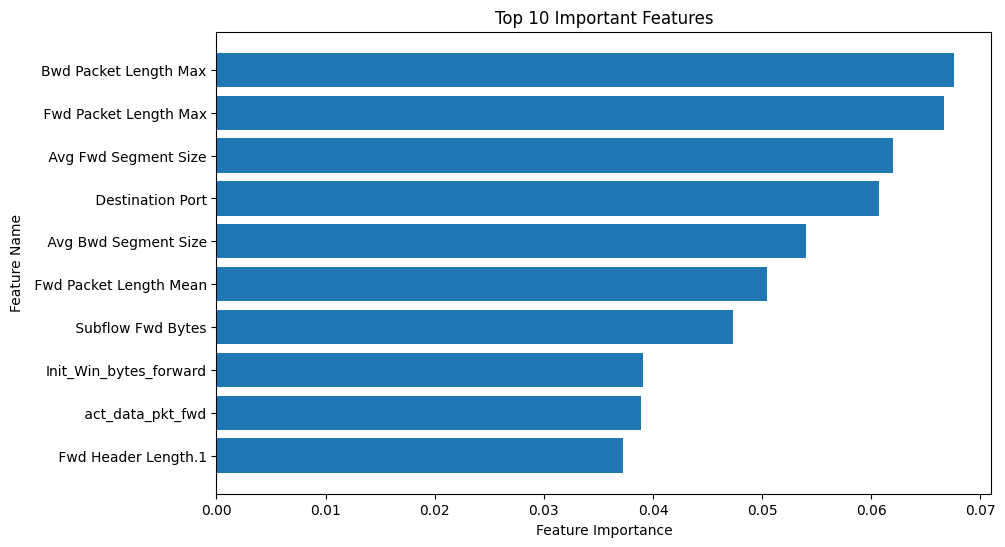

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure you have the column names from your original DataFrame
feature_names = df.drop(columns=[' Label']).columns  # Use correct label column name

feature_importance = model.feature_importances_

# Create a DataFrame and sort by importance
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

# Plot the top 10 most important features
plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['Feature'][:10], feat_imp_df['Importance'][:10])
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Top 10 Important Features")
plt.gca().invert_yaxis()
plt.show()


In [ ]:
import joblib

joblib.dump(model, "trained_model.pkl")
print("Model saved successfully!")


Model saved successfully!


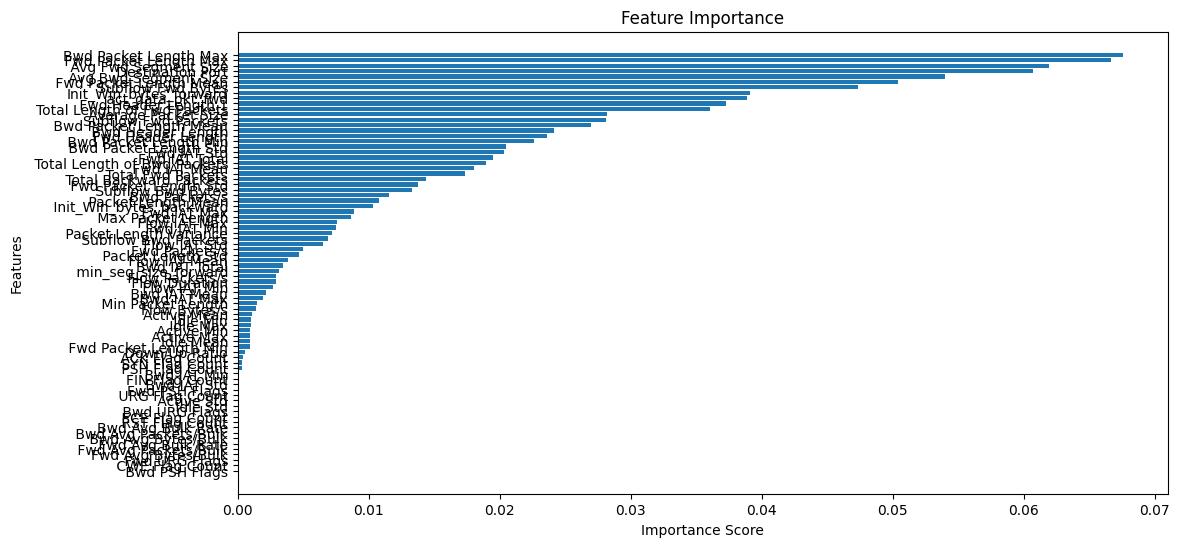

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert X_train to DataFrame (if it is a NumPy array)
X_train_df = pd.DataFrame(X_train, columns=feature_names)  # Ensure feature_names are correctly assigned

# Extract feature importance
feature_importance = model.feature_importances_

# Create DataFrame for visualization
importance_df = pd.DataFrame({'Feature': X_train_df.columns, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()


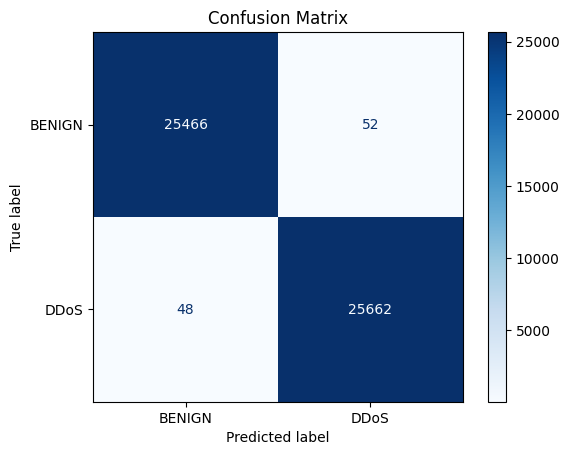

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions on the test set
y_pred = model.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


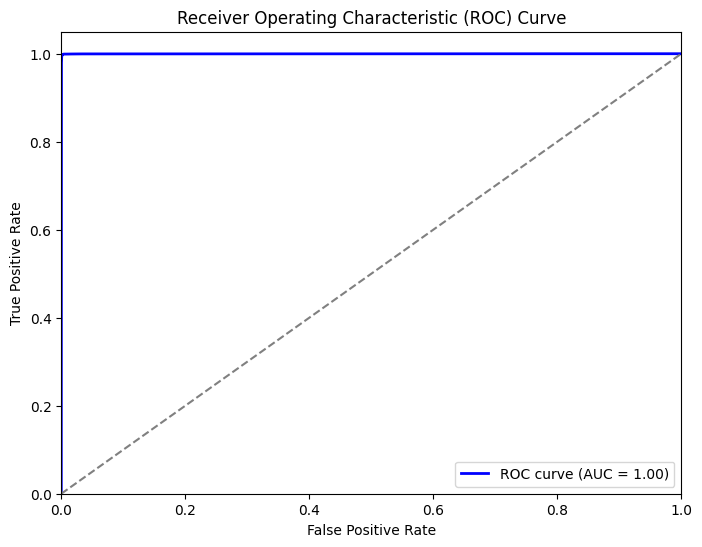

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc

# Encode labels (BENIGN -> 0, DDoS -> 1)
lb = LabelBinarizer()
y_test_binary = lb.fit_transform(y_test).ravel()  # Convert to 1D array if needed

# Get prediction probabilities
y_probs = model.predict_proba(X_test)[:, 1]  # Probabilities for positive class (DDoS)

# Compute ROC curve and AUC score
fpr, tpr, _ = roc_curve(y_test_binary, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_probs, pos_label='DDoS')


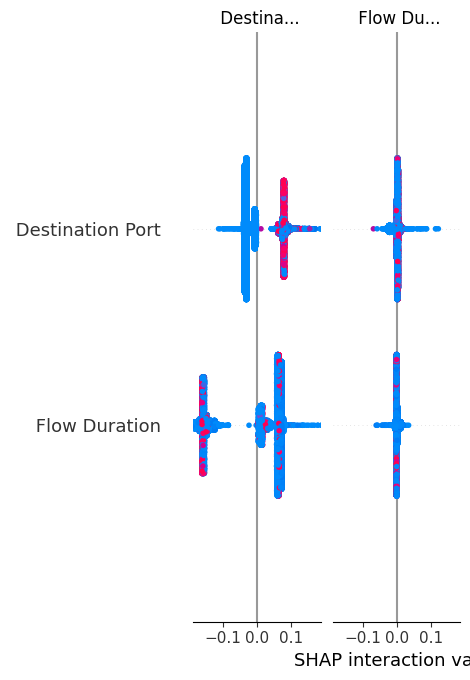

In [ ]:
import shap
import joblib
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np #Import numpy

# Load the saved model
model = joblib.load("trained_model.pkl")

# Load the saved dataframe with the proper column names
df = pd.read_csv('CICIDS2017.csv')
feature_names = df.drop(columns=[' Label']).columns

# Load the data needed for X_test and instantiate as a dataframe
X = df.drop(columns=[' Label']).values
y = df[' Label'].values

min_length = min(len(X), len(y))

X = X[:min_length]
y = y[:min_length]

df_combined = pd.DataFrame(X)
df_combined['Label'] = y
df_combined.dropna(inplace=True)
X = df_combined.drop(columns=['Label']).values  # Convert to NumPy
y = df_combined['Label'].values
X = np.nan_to_num(X, nan=0.0, posinf=np.nanmax(X[np.isfinite(X)]), neginf=np.nanmin(X[np.isfinite(X)]))

from imblearn.over_sampling import ADASYN
adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X, y)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


explainer = shap.TreeExplainer(model)  # Use appropriate explainer for your model
shap_values = explainer.shap_values(X_test)

# Summary Plot
shap.summary_plot(shap_values, X_test, feature_names=feature_names)